In [43]:
import json
import os
from pprint import pprint
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from collections import Counter
import pandas as pd
from transformers import RobertaTokenizerFast
from wordcloud import WordCloud, STOPWORDS
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
pd.set_option('display.max_columns', 500)

# expects pandas == 2.0.1 and sns == 0.12.2
# installing requirements file sets pandas == 2.0.3

In [12]:
SRC_DIRECTORY = r"C:\Users\vsornapudi\Documents\github\setup_training_environment\machine-reading-comprehension\src"

TRAINSET_PATH = os.path.join(SRC_DIRECTORY, 'data', "squad", 'train-v2.0.json')
DEVSET_PATH = os.path.join(SRC_DIRECTORY, 'data', "squad", 'dev-v2.0.json')

PROCESSED_TRAINSET_PATH = os.path.join(SRC_DIRECTORY, 'outputs', "squad", "processed_train_2017", 'squad_like_json.json')
PROCESSED_DEVSET_PATH = os.path.join(SRC_DIRECTORY, 'outputs', "squad", "processed_dev_2017", 'squad_like_json.json')

In [13]:
def squad_load(data_path):
    """
    Loads train/dev/test dataset json file.

    :param data_path: path to data file to read json from
    :return: list of documents in the dataset
    """
    with open(data_path, 'r') as f:
        docs = json.load(f)
    return docs

In [29]:
def print_1d_stats(vector_1d):
    print(f"Maximum of {np.max(vector_1d)} at index<{np.argmax(vector_1d)}>")
    print(f"Mininmun of {np.min(vector_1d)} at index<{np.argmin(vector_1d)}>")
    print(f"Mean is {np.mean(vector_1d)}")
    print(f"Variance is {np.var(vector_1d)}")
    print(f"Median is {np.median(vector_1d)}")


def generate_1d_graphs(vector, title):
    fig, axes = plt.subplots(1,2, figsize=(8,4))
    sns.boxplot(data=vector, ax=axes[0])
    try:
        bin_edges = np.arange(0, max(vector), int(max(vector)/15))
        sns.histplot(vector, kde=True, bins=bin_edges, ax=axes[1])
        axes[1].set_xticks(bin_edges[::2])
    except:
        sns.histplot(vector, kde=True, bins=15, ax=axes[1])
    fig.suptitle(title)
    fig.tight_layout(pad=3.0)
    plt.show()

def generate_wordcloud(phrases, title):
    wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = set(STOPWORDS),
                min_font_size = 10).generate(" ".join(phrases))
 
    # plot the WordCloud image                      
    plt.figure(figsize = (4, 4), facecolor = None)
    plt.imshow(wordcloud)
    plt.title(title)
    plt.axis("off")
    plt.tight_layout(pad = 0)
    plt.show()    

def flatten(l):
    return [item for sublist in l for item in sublist]

def first_2_words_piechart(strings):

    word1 = flatten([string[0:1] for string in strings])
    word2 = flatten([string[1:2] for string in strings])

    len_word1 = len(word1)
    len_word2 = len(word2)

    word1 = Counter(word1)
    word2 = Counter(word2)

    word1_values = [int(100* value / len_word1) for value in word1.values()]
    word2_values = [int(100* value / len_word2) for value in word2.values()]

    cleaned_word1_values = [value for value in word1_values if value > 1]
    cleaned_word2_values = [value for value in word2_values if value > 1]

    others_word1_values = sum([value for value in word1_values if value <= 1])
    others_word2_values = sum([value for value in word2_values if value <= 1])
    cleaned_word1_values.append(others_word1_values)
    cleaned_word2_values.append(others_word2_values)

    cleaned_word1_keys = [key for i, key in enumerate(word1.keys()) if word1_values[i] > 1]
    cleaned_word2_keys = [key for i, key in enumerate(word2.keys()) if word2_values[i] > 1]
    cleaned_word1_keys.append("'others'")
    cleaned_word2_keys.append("'others'")

    fig, ax = plt.subplots(figsize=(8,10))
    size = 0.4

    ax.pie(cleaned_word1_values, 
        radius=1,
        labels=cleaned_word1_keys,
        labeldistance = 0.7,
        wedgeprops=dict(width=size, edgecolor='w'),
        rotatelabels =True)

    ax.pie(cleaned_word2_values, 
        radius=1-size, 
        labels = cleaned_word2_keys,
        labeldistance = 0.5,
        wedgeprops=dict(width=size, edgecolor='w'),
        rotatelabels =True)

    ax.set(aspect="equal", title='First 2 words of questions')
    plt.show()

In [33]:
def stats_and_graphs(docs):

    print(f"Number of documents: {len(docs)}\n")
    n_qas_per_para = []

    qa_list = []
    for doc in docs:
        for para in doc['paragraphs']:
            for qas in para['qas']:
                qa_list.append(qas)
                n_qas_per_para.append(len(qas))

    questions = [qas['question'].strip() for qas in qa_list] #### strip is must####
    answers = [[answer['text'].strip() for answer in qas['answers']] for qas in qa_list if not qas['is_impossible']]

    # questions stats

    print("QUESTIONS -------->\n")
    print(f"Number of questions: {len(questions)}")
    print(f"Number of unique questions: {len(set(questions))}\n")

    questions_words = []
    for question in questions:
        questions_words.extend(question.split(" "))
    print(f"Number of distinct words in questions: {len(set(questions_words))}")

    generate_wordcloud(questions_words, "Words in questions")

    questions_lengths = [len(question.split(" ")) for question in questions]
    print("\n|| Question length stats:")
    print_1d_stats(questions_lengths)
    generate_1d_graphs(questions_lengths, 'Question lengths')

    n_answers = 0
    n_q_per_doc = {}
    n_aq_per_doc = {}
    n_q_per_para = {}
    n_aq_per_para = {}
    for doc_id, doc in enumerate(docs):
        for i, para in enumerate(doc['paragraphs']):
            if doc_id not in n_q_per_doc:
                n_q_per_doc[doc_id] = len(para['qas'])
            else:
                n_q_per_doc[doc_id] += len(para['qas'])

            if (doc_id,i) not in n_q_per_para:
                n_q_per_para[(doc_id,i)] = len(para['qas'])
            else:
                n_q_per_para[(doc_id,i)] += len(para['qas'])

            for qas in para['qas']:
                if not qas['is_impossible']:
                    n_answers += len(qas['answers'])
                    if doc_id not in n_aq_per_doc:
                        n_aq_per_doc[doc_id] = 1
                    else:
                        n_aq_per_doc[doc_id] += 1

                    if (doc_id,i) not in n_aq_per_para:
                        n_aq_per_para[(doc_id,i)] = 1
                    else:
                        n_aq_per_para[(doc_id,i)] += 1

    n_q_per_doc = list(n_q_per_doc.values())
    print("\n|| # Questions per document stats:")
    print_1d_stats(n_q_per_doc)
    generate_1d_graphs(n_q_per_doc, '# Questions per document')

    n_aq_per_doc = list(n_aq_per_doc.values())
    print(f"Number of answerable questions: {sum(n_aq_per_doc)}") 

    print("\n|| # Answerable questions per document stats:")
    print_1d_stats(n_aq_per_doc)
    generate_1d_graphs(n_aq_per_doc, '# Answerable questions per document')

    n_q_per_para = list(n_q_per_para.values())
    print("\n|| # Questions per paragraph stats:")
    print_1d_stats(n_q_per_para)
    generate_1d_graphs(n_q_per_para, '# Questions per paragraph')

    n_aq_per_para = list(n_aq_per_para.values())
    print("\n|| # Answerable questions per paragraph stats:")
    print_1d_stats(n_aq_per_para)
    generate_1d_graphs(n_aq_per_para, '# Answerable questions per paragraph')

    first_2q_words = []
    for question in questions:
        first_2q_words.append(question.split(" ")[:2])
    first_2_words_piechart(first_2q_words)
   
    # answer stats

    print("\nANSWERS -------->\n")

    print(f"Number of answers (including all multiple answers): {n_answers}")

    # n distinct words in answers
    answers_words = []
    for answer in answers:
        for ans in answer:
            answers_words.extend(ans.split(" "))
    print(f"Number of distinct words in answers: {len(set(answers_words))}")

    generate_wordcloud(answers_words, "Words in answers")

    answer_lengths = [np.mean([len(ans.split(" ")) for ans in answer]) for answer in answers]
    print("\n|| Answer length stats:")
    print_1d_stats(answer_lengths)
    generate_1d_graphs(answer_lengths, 'Answer lengths') 

    n_answers_per_question = [len(qas['answers']) for qas in qa_list]
    n_impossible_questions = sum([1 for n_answers in n_answers_per_question if n_answers==0])
    n_single_answers = sum([1 for n_answers in n_answers_per_question if n_answers==1])
    n_multi_answers = sum([1 for n_answers in n_answers_per_question if n_answers>1])

    print(f"Number of unanswerable questions: {n_impossible_questions}")
    print(f"Number of questions having one answer: {n_single_answers}")
    print(f"Number of questions having more than one answer: {n_multi_answers}")

    print("\n|| Answers per question stats:")
    print_1d_stats(n_answers_per_question)
    generate_1d_graphs(n_answers_per_question, '# Answers per question') 

    # paragraph stats
    print("\nPARAGRAPHS -------->\n")

    paras = {}
    for doc_id, doc in enumerate(docs):
        paras[doc_id] = [para['context'] for para in doc['paragraphs']]
    para_list = flatten(paras.values())

    print(f"Number of paragraphs in dataset: {len(flatten(paras.values()))}")

    generate_wordcloud(para_list, "Words in paragraphs")

    para_lengths = [len(para.split(" ")) for para in para_list]
    print("\n|| Paragraph length stats:")
    print_1d_stats(para_lengths)
    generate_1d_graphs(para_lengths, 'Paragraph lengths')

    para_counts = [len(para) for para in paras.values()]
    print("\n|| # Paragraphs per doc stats:")
    print_1d_stats(para_counts)
    generate_1d_graphs(para_counts, '# Paragraphs per doc')


# Original Dataset

SQuAD 2.0 data

In [27]:
org_docs = squad_load(TRAINSET_PATH)['data'] + squad_load(DEVSET_PATH)['data']

Number of documents: 477

QUESTIONS -------->

Number of questions: 142192
Number of unique questions: 142040

Number of distinct words in questions: 80457


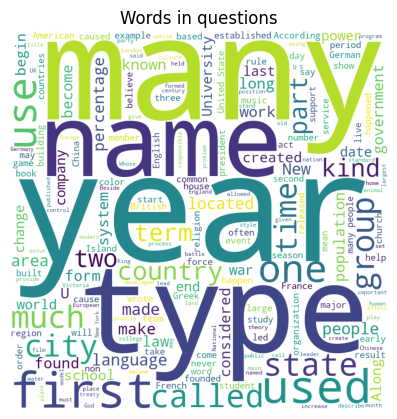


|| Question length stats:
Maximum of 40 at index<45706>
Mininmun of 1 at index<50678>
Mean is 9.911134241026218
Variance is 11.766084535484467
Median is 9.0


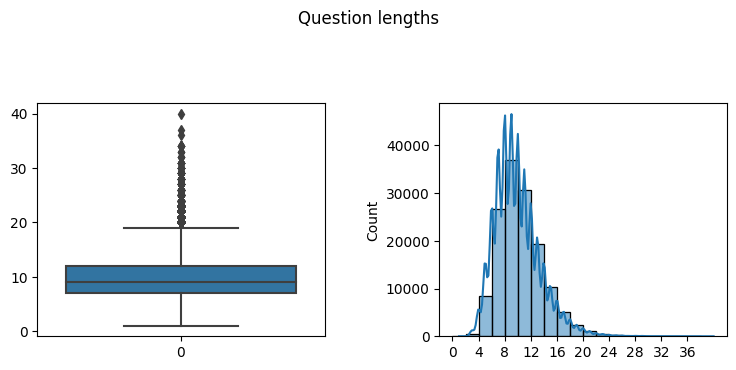


|| # Questions per document stats:
Maximum of 883 at index<171>
Mininmun of 36 at index<105>
Mean is 298.0964360587002
Variance is 11636.166800715513
Median is 282.0


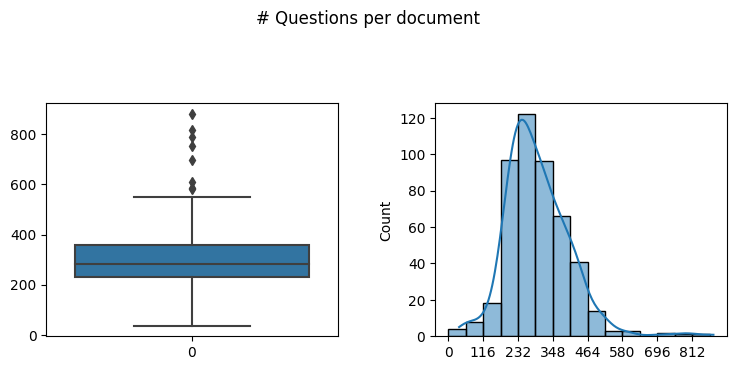

Number of answerable questions: 92749

|| # Answerable questions per document stats:
Maximum of 817 at index<7>
Mininmun of 36 at index<105>
Mean is 195.26105263157893
Variance is 12732.689746260388
Median is 169.0


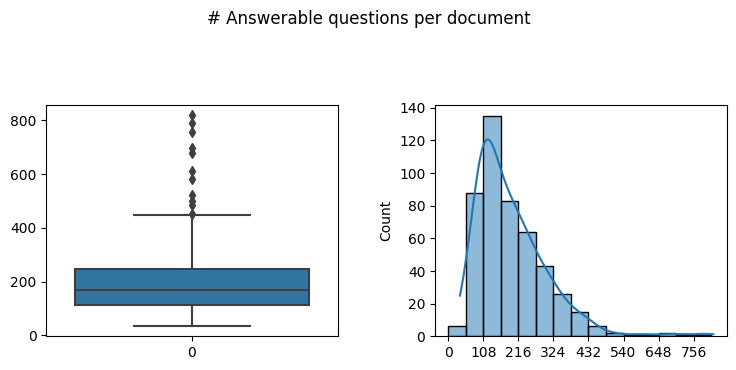


|| # Questions per paragraph stats:
Maximum of 30 at index<7712>
Mininmun of 1 at index<148>
Mean is 7.025643559464401
Variance is 9.81212960090113
Median is 7.0


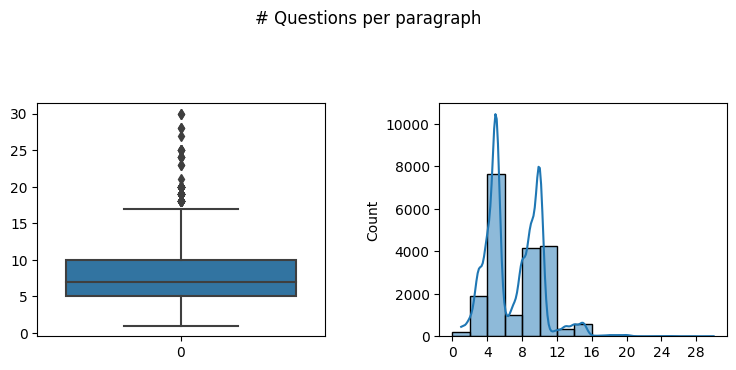


|| # Answerable questions per paragraph stats:
Maximum of 25 at index<7662>
Mininmun of 1 at index<148>
Mean is 4.617594344319427
Variance is 2.6051848132389486
Median is 5.0


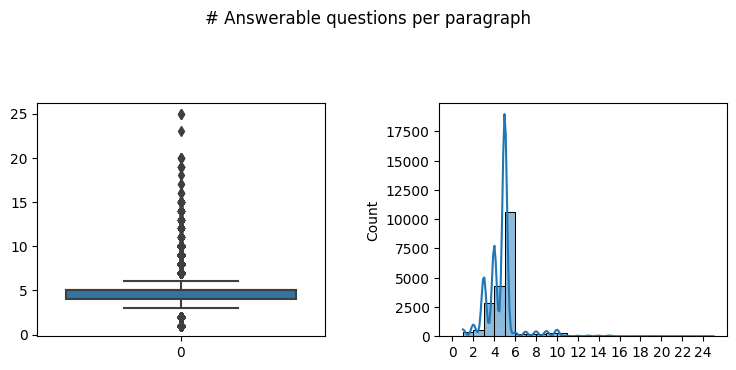

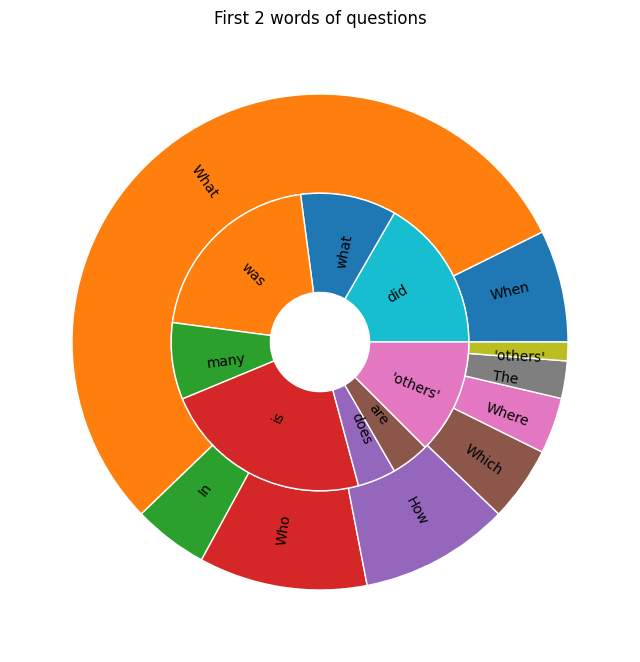


ANSWERS -------->

Number of answers (including all multiple answers): 107123
Number of distinct words in answers: 58454


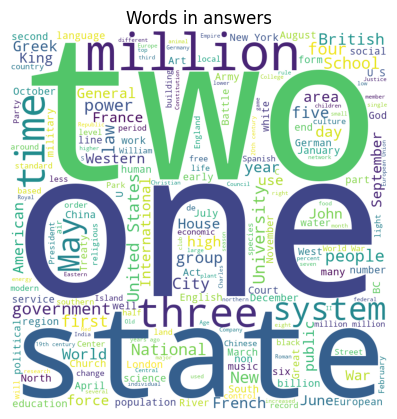


|| Answer length stats:
Maximum of 43.0 at index<2853>
Mininmun of 1.0 at index<2>
Mean is 3.1550604319184035
Variance is 11.202759414568725
Median is 2.0


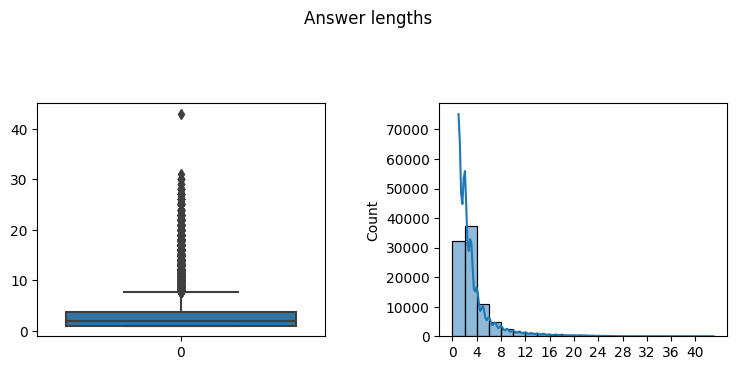

Number of unanswerable questions: 49443
Number of questions having one answer: 86822
Number of questions having more than one answer: 5927

|| Answers per question stats:
Maximum of 6 at index<135986>
Mininmun of 0 at index<2075>
Mean is 0.7533686845954766
Variance is 0.5580756048165774
Median is 1.0


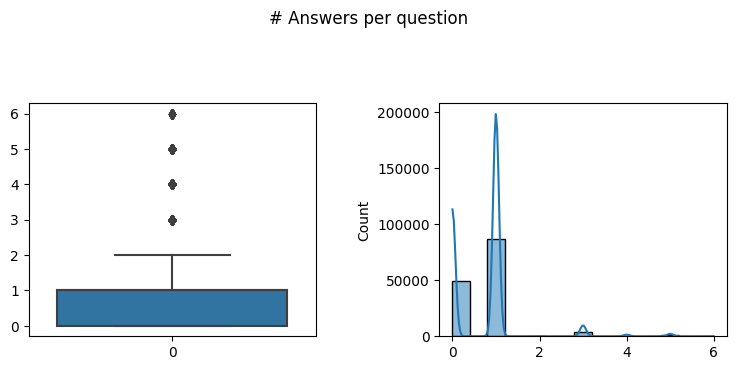


PARAGRAPHS -------->

Number of paragraphs in dataset: 20239


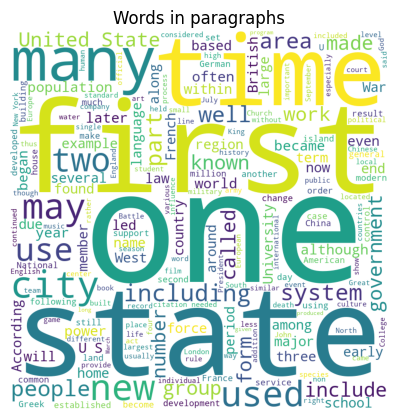


|| Paragraph length stats:
Maximum of 653 at index<12251>
Mininmun of 20 at index<2199>
Mean is 117.17930727802757
Variance is 2522.4925289731727
Median is 108.0


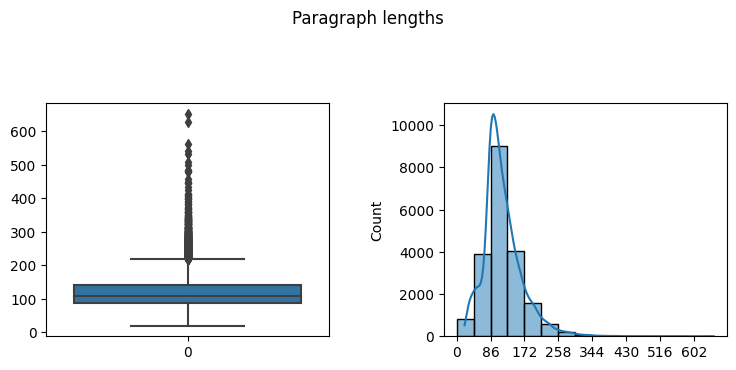


|| # Paragraphs per doc stats:
Maximum of 149 at index<11>
Mininmun of 10 at index<105>
Mean is 42.42976939203354
Variance is 437.8844806596082
Median is 37.0


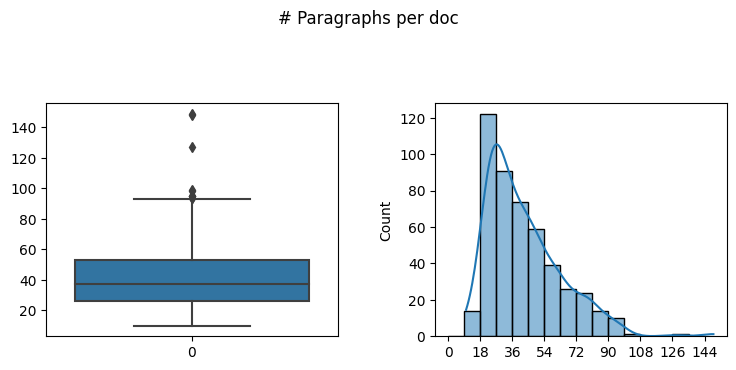

In [34]:
stats_and_graphs(org_docs)

# Processed Dataset

Visual SQuAD data after data transformation

Number of documents: 457

QUESTIONS -------->

Number of questions: 124827
Number of unique questions: 124692

Number of distinct words in questions: 74689


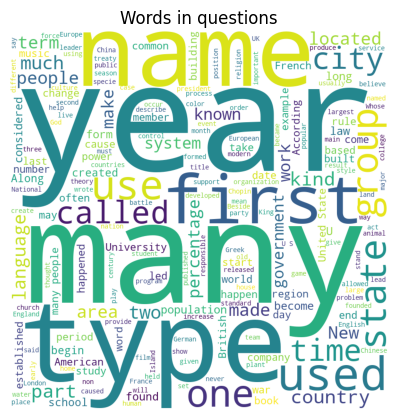


|| Question length stats:
Maximum of 40 at index<40231>
Mininmun of 1 at index<44398>
Mean is 9.883366579345815
Variance is 11.646414109356915
Median is 9.0


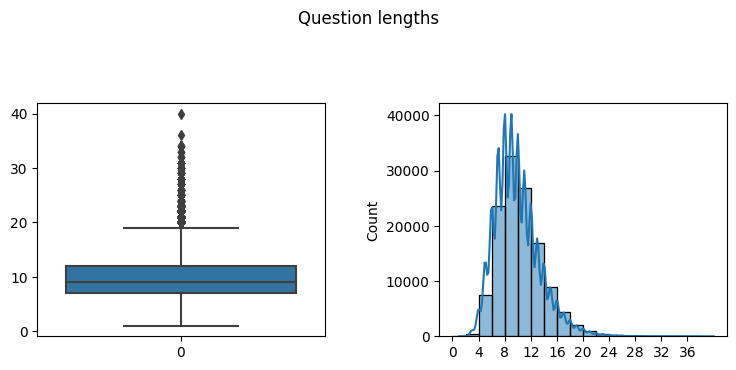


|| # Questions per document stats:
Maximum of 867 at index<167>
Mininmun of 36 at index<105>
Mean is 273.14442013129104
Variance is 10351.33581678629
Median is 256.0


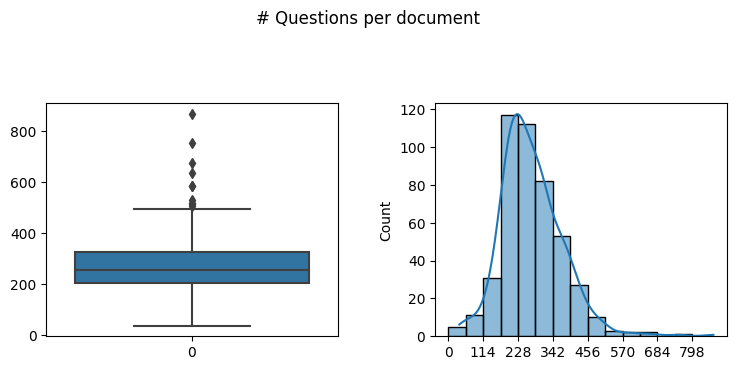

Number of answerable questions: 77510

|| # Answerable questions per document stats:
Maximum of 752 at index<12>
Mininmun of 21 at index<38>
Mean is 171.48230088495575
Variance is 10460.869155767874
Median is 145.0


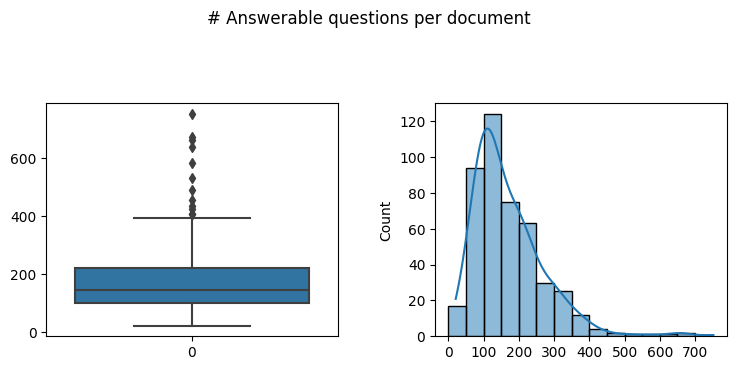


|| # Questions per paragraph stats:
Maximum of 173 at index<7177>
Mininmun of 1 at index<67>
Mean is 6.622122015915119
Variance is 12.53609417078851
Median is 5.0


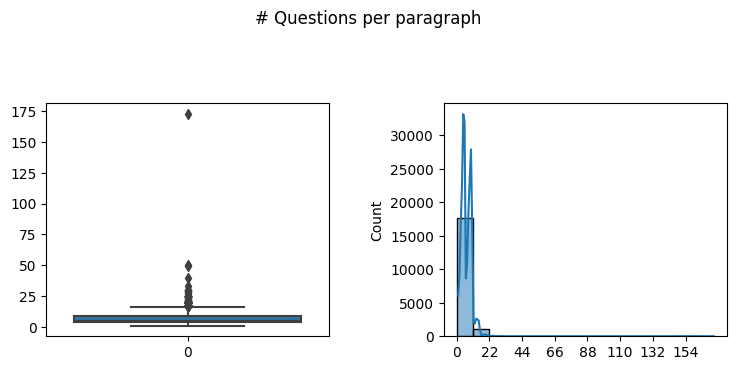


|| # Answerable questions per paragraph stats:
Maximum of 25 at index<6998>
Mininmun of 1 at index<67>
Mean is 4.216624959199216
Variance is 2.9544880542089396
Median is 4.0


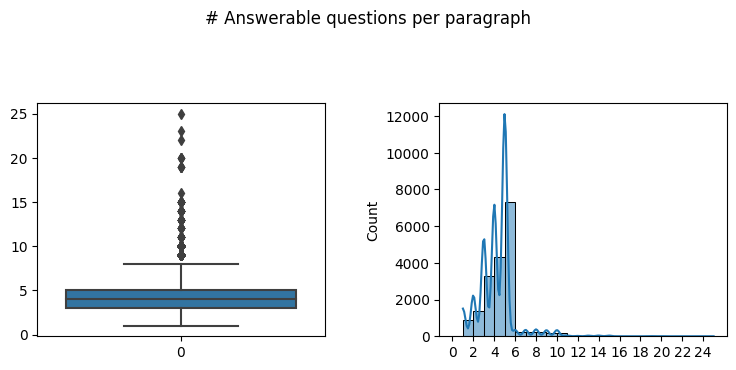

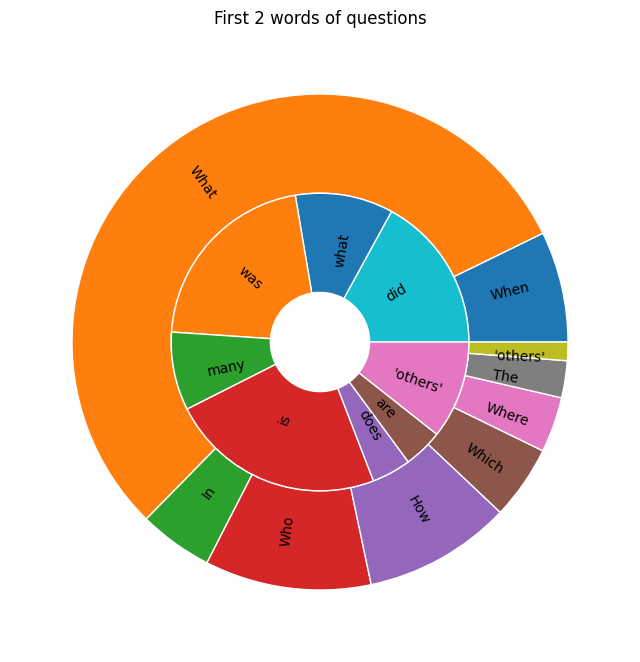


ANSWERS -------->

Number of answers (including all multiple answers): 81073
Number of distinct words in answers: 51010


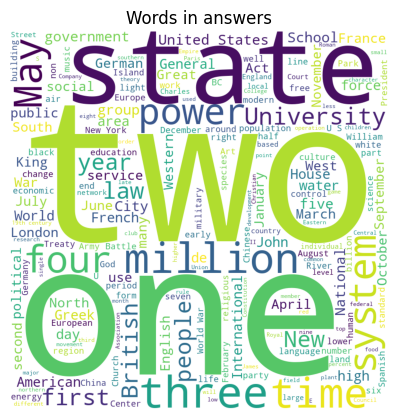


|| Answer length stats:
Maximum of 43.0 at index<2352>
Mininmun of 1.0 at index<2>
Mean is 3.118057239926031
Variance is 10.833500557024053
Median is 2.0


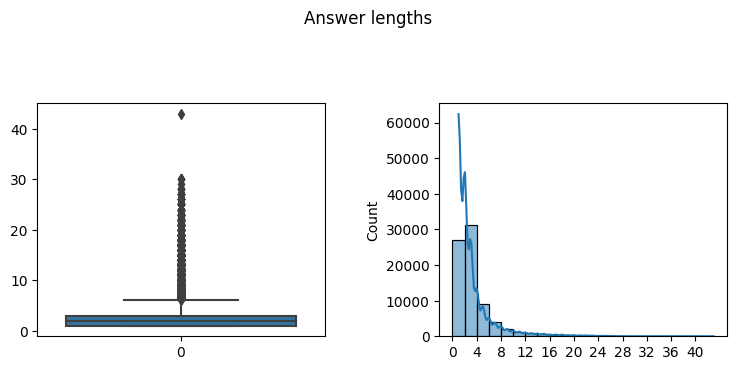

Number of unanswerable questions: 47317
Number of questions having one answer: 74944
Number of questions having more than one answer: 2566

|| Answers per question stats:
Maximum of 5 at index<119025>
Mininmun of 0 at index<1784>
Mean is 0.6494828843118876
Variance is 0.3040966627426946
Median is 1.0


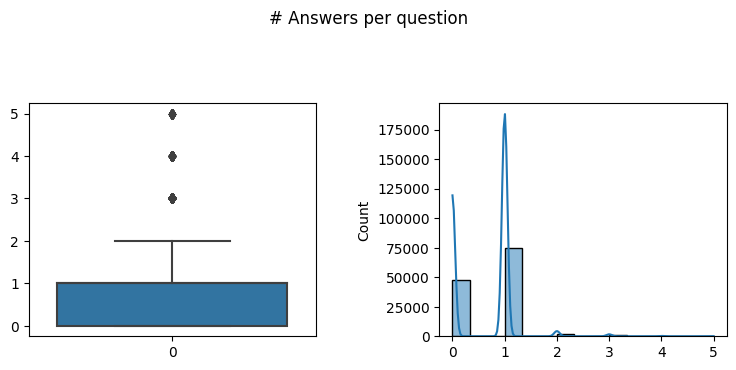


PARAGRAPHS -------->

Number of paragraphs in dataset: 18850


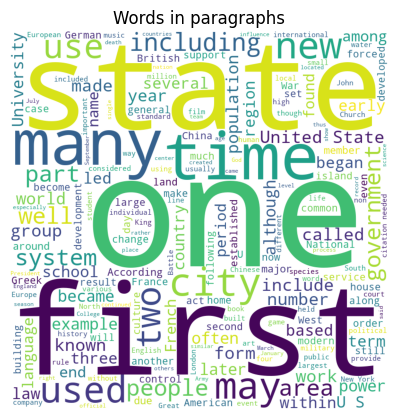


|| Paragraph length stats:
Maximum of 562 at index<12600>
Mininmun of 8 at index<14479>
Mean is 116.73761273209549
Variance is 2555.343036210766
Median is 108.0


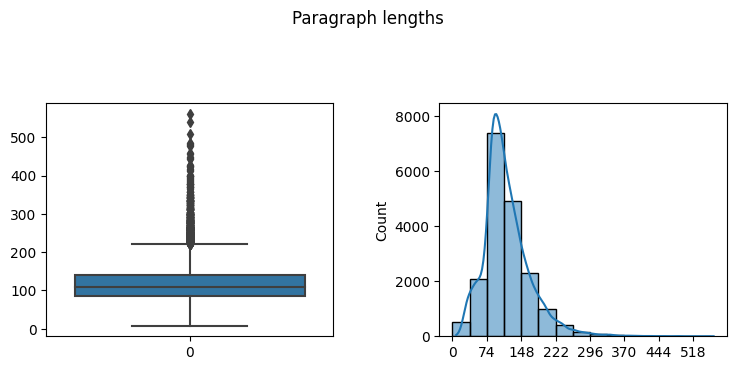


|| # Paragraphs per doc stats:
Maximum of 139 at index<7>
Mininmun of 1 at index<166>
Mean is 41.2472647702407
Variance is 391.5034115557173
Median is 36.0


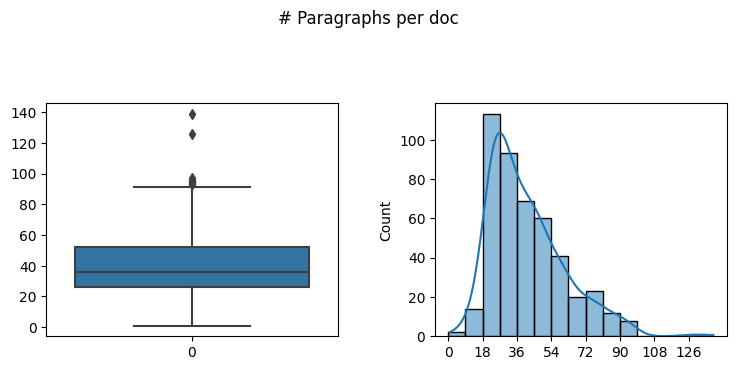

In [35]:
PROCESSED_DATASET_PATH = r"C:\Users\vsornapudi\Documents\github\setup_training_environment\machine-reading-comprehension\src\outputs\29_06_data\squad_like_json.json"
stats_and_graphs(squad_load(PROCESSED_DATASET_PATH))

# Modelling data

It is the data obtained after breaking each document from Visual SQuAD data into 1 page documents, removing questions from paragraphs that do not completely occur in any page, splitting multiple answer question-answers into separate question-answer pairs and ignoring impossible/unanswerable questions

In [47]:
SRC_DIRECTORY = r"C:\Users\vsornapudi\Documents\github\long_doc_runs\machine-reading-comprehension\src"
OUTPUT_DIR = os.path.join(SRC_DIRECTORY, "outputs", "squad", "18_07_page_docs_data")
MODELLING_DATA_PATH = os.path.join(OUTPUT_DIR, "modelling_data.json")
qas_df = pd.read_json(MODELLING_DATA_PATH, orient="records")

QUESTIONS -------->

Number of question-answer pairs: 53391. This is same as number of answers
Number of questions: 51174
Number of unique questions: 51146

Number of distinct words in questions: 46658


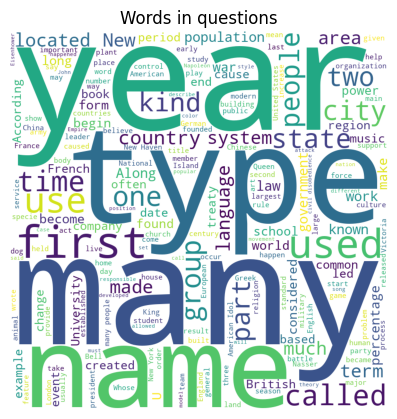


|| Question length stats over all question-answer pairs:
Maximum of 40 at index<18622>
Mininmun of 1 at index<20381>
Mean is 10.167369032233896
Variance is 12.928253644396206
Median is 10.0


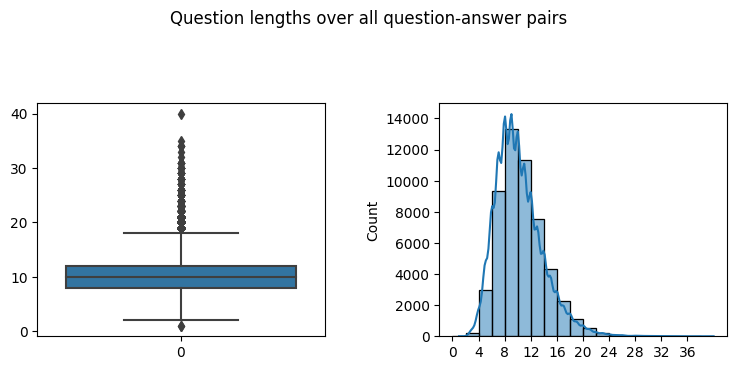


|| # Question-answer pairs per document stats:
Maximum of 115 at index<570>
Mininmun of 1 at index<101>
Mean is 13.817546583850932
Variance is 97.74543745901006
Median is 12.0


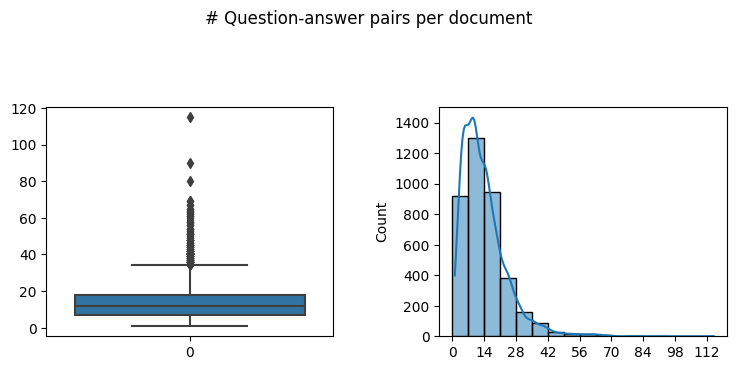

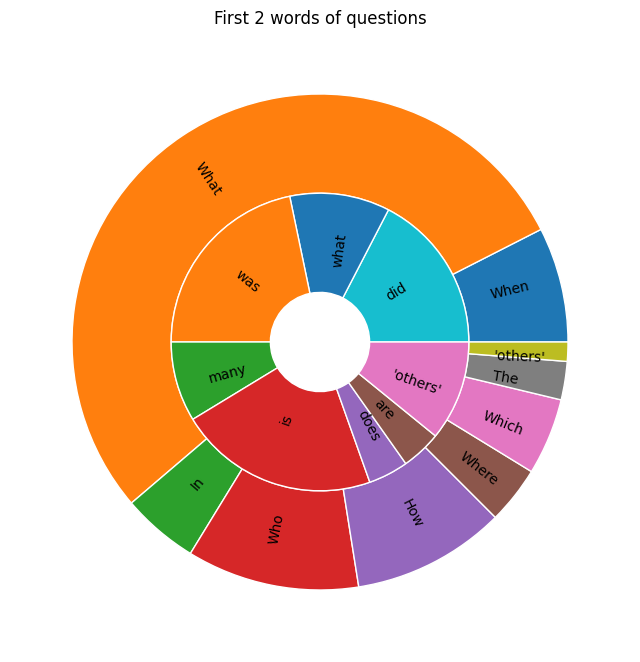


Number of wikipages: 451

|| # Question-answer pairs per wikipage stats:
Maximum of 509 at index<22>
Mininmun of 5 at index<153>
Mean is 118.38359201773837
Variance is 5645.424919248185
Median is 97.0


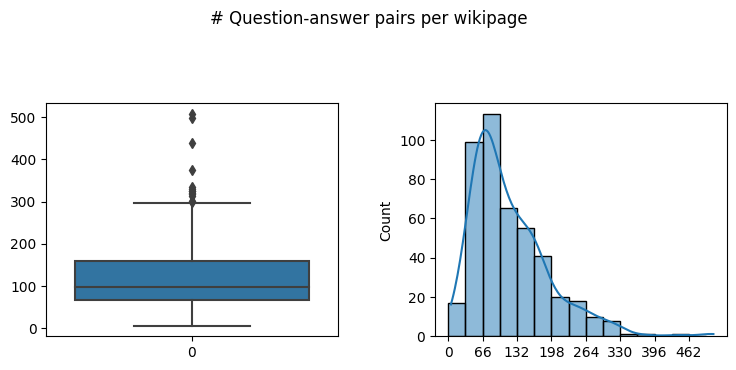


|| # Question-answer pairs per complete paragraph stats:
Maximum of 30 at index<9727>
Mininmun of 1 at index<43>
Mean is 4.371653156472611
Variance is 4.145915526305643
Median is 4.0


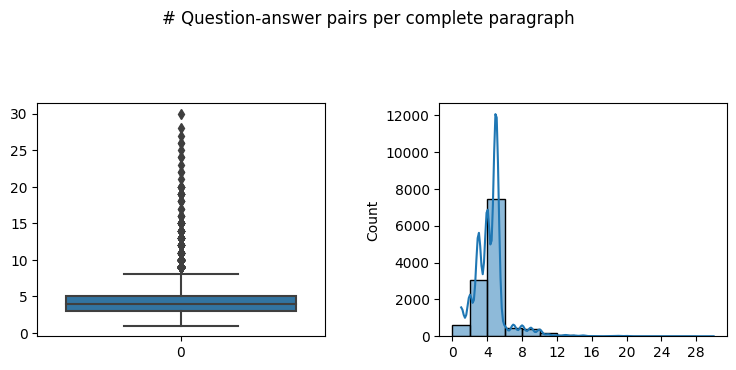

In [48]:
# questions stats

print("QUESTIONS -------->\n")
print(f"Number of question-answer pairs: {len(qas_df)}. This is same as number of answers")
print(f"Number of questions: {len(qas_df['qas_id'].unique())}")
print(f"Number of unique questions: {len(qas_df['question'].unique())}\n")

questions_words = []
for question in qas_df['question']:
    questions_words.extend(question.split(" "))
print(f"Number of distinct words in questions: {len(set(questions_words))}")

generate_wordcloud(questions_words, "Words in questions")

questions_lengths = [len(question.split(" ")) for question in qas_df['question']]
print("\n|| Question length stats over all question-answer pairs:")
print_1d_stats(questions_lengths)
generate_1d_graphs(questions_lengths, 'Question lengths over all question-answer pairs')

def get_doc_id_and_page_nr(image_path):
    sep_image_path = os.path.normpath(image_path)
    path_parts = sep_image_path.split(os.sep)
    doc_id = path_parts[4]
    page_nr = path_parts[6]
    return doc_id, page_nr

qas_df["doc_id"], qas_df["page_nr"] = zip(*qas_df['image_path'].map(get_doc_id_and_page_nr))

grouped_by_doc = qas_df.groupby(["doc_id", "page_nr"])
n_docs = len(grouped_by_doc)
n_qas_per_doc = grouped_by_doc.size().to_list()

print("\n|| # Question-answer pairs per document stats:")
print_1d_stats(n_qas_per_doc)
generate_1d_graphs(n_qas_per_doc, '# Question-answer pairs per document')

first_2q_words = []
for question in qas_df['question'].unique():
    first_2q_words.append(question.split(" ")[:2])
first_2_words_piechart(first_2q_words)

grouped_by_wikipage = qas_df.groupby(["doc_id"])
n_wikipages = len(grouped_by_wikipage)
n_qas_per_wikipage = grouped_by_wikipage.size().to_list()
print(f"\nNumber of wikipages: {n_wikipages}")
print("\n|| # Question-answer pairs per wikipage stats:")
print_1d_stats(n_qas_per_wikipage)
generate_1d_graphs(n_qas_per_wikipage, '# Question-answer pairs per wikipage')

grouped_by_para = qas_df.groupby(["doc_id", "idx_para_matched"])
n_qas_per_para = grouped_by_para.size().to_list()
print("\n|| # Question-answer pairs per complete paragraph stats:")
print_1d_stats(n_qas_per_para)
generate_1d_graphs(n_qas_per_para, '# Question-answer pairs per complete paragraph')


ANSWERS -------->

Number of distinct words in answers: 38445

|| Answer length stats:
Maximum of 30 at index<20842>
Mininmun of 1 at index<2>
Mean is 3.17516060759304
Variance is 11.099321945604876
Median is 2.0


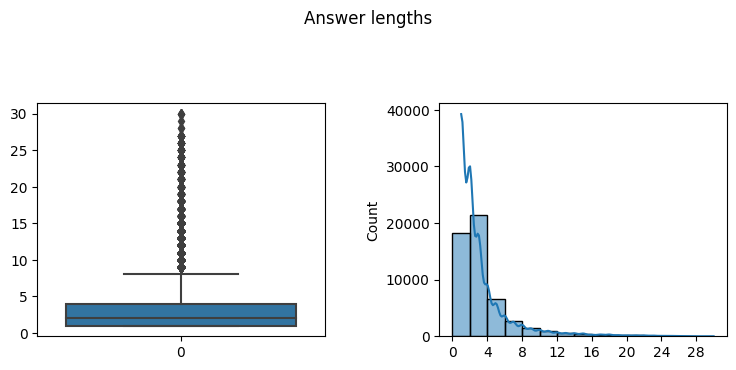

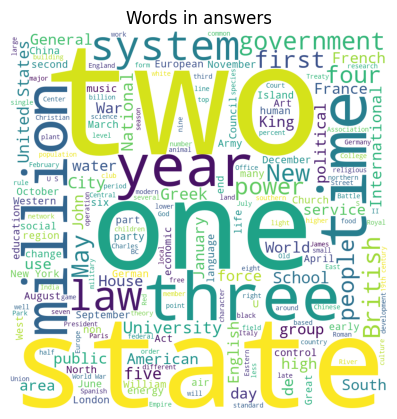

In [38]:
# answer stats

print("\nANSWERS -------->\n")
answer_lengths = [len(answer.split(" ")) for answer in qas_df['answer_text']]

# n distinct words in answers
answers_words = []
for ans in qas_df['answer_text']:
    answers_words.extend(ans.split(" "))
print(f"Number of distinct words in answers: {len(set(answers_words))}")

print("\n|| Answer length stats:")
print_1d_stats(answer_lengths)
generate_1d_graphs(answer_lengths, 'Answer lengths') 

generate_wordcloud(answers_words, "Words in answers")


\DOCUMENTS -------->

Number of documents: 3864

|| Document length stats:
Maximum of 1958 at index<145>
Mininmun of 48 at index<493>
Mean is 846.5012939958592
Variance is 34840.2810542262
Median is 867.0


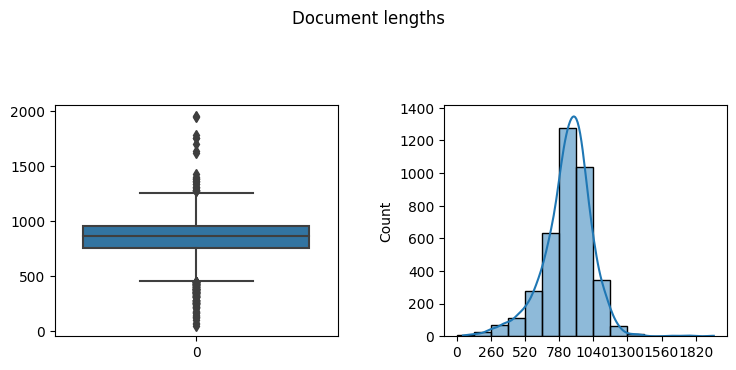

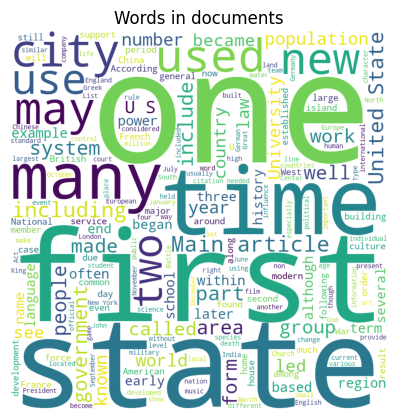

In [39]:
# context stats

print("\DOCUMENTS -------->\n")

print(f"Number of documents: {n_docs}")

qas_df_with_unique_doc = qas_df.drop_duplicates('image_path')

doc_texts = []

for image_path in qas_df_with_unique_doc['image_path']:
    text_file_path = os.path.join(
        SRC_DIRECTORY, image_path.replace("image.png", "text.txt")
    )
    with open(text_file_path, "r", encoding="utf-8") as file:
        doc_texts.append(file.read().replace("\n", " "))

doc_lengths = [len(doc_text.split(" ")) for doc_text in doc_texts]
print("\n|| Document length stats:")
print_1d_stats(doc_lengths)
generate_1d_graphs(doc_lengths, 'Document lengths')

generate_wordcloud(doc_texts, "Words in documents")

\COMPLETE PARAGRAPHS -------->

Number of complete paragraphs in dataset: 12213

|| Document length stats:
Maximum of 562 at index<8321>
Mininmun of 8 at index<9469>
Mean is 110.3551134037501
Variance is 2183.933093684429
Median is 103.0


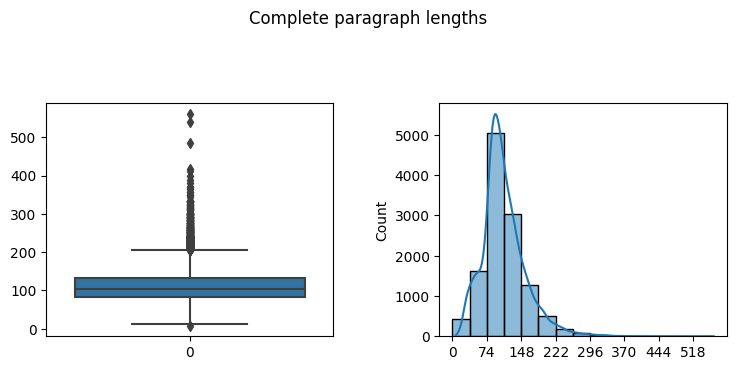


|| # Paragraphs per doc stats:
Maximum of 13 at index<3653>
Mininmun of 1 at index<9>
Mean is 3.1607142857142856
Variance is 3.550516674060929
Median is 3.0


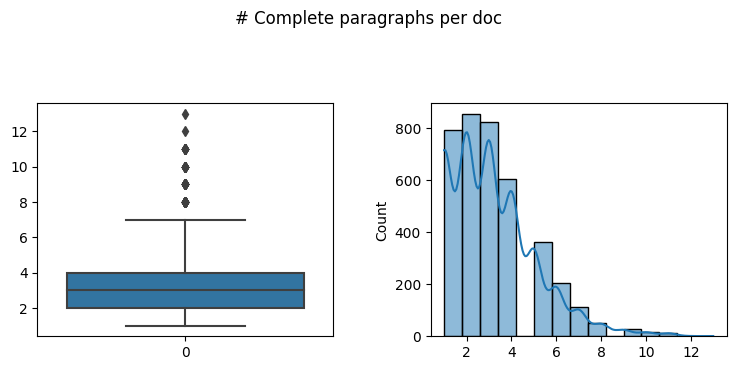

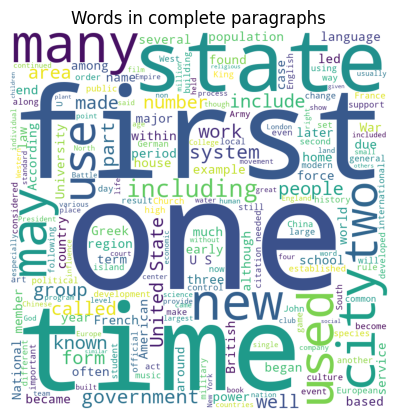

In [40]:
# paragraphs that are fully contained (don't go to next page or don't continue from next page) in a page/document stats

print("\COMPLETE PARAGRAPHS -------->\n")

doc_paras_path = os.path.join(OUTPUT_DIR, "doc_paras.json")
with open(doc_paras_path, "r", encoding="utf-8") as f:
    df_doc_paras = pd.DataFrame.from_dict(json.load(f))

para_texts = []

unique_para_qas_df = qas_df.drop_duplicates(['doc_id', 'page_nr', 'idx_para_matched'])

for row_idx, qas in unique_para_qas_df.iterrows():
    para_texts.append(df_doc_paras[df_doc_paras["doc_id"] == int(qas['doc_id'])]["paras"].values[0][qas['idx_para_matched']]) # [[para1, ...] ... for n_docs]\

print(f"Number of complete paragraphs in dataset: {len(unique_para_qas_df)}")

para_lengths = [len(doc_text.split(" ")) for doc_text in para_texts]
print("\n|| Document length stats:")
print_1d_stats(para_lengths)
generate_1d_graphs(para_lengths, 'Complete paragraph lengths')

para_counts = []
for _, doc_group in grouped_by_doc:
    para_counts.append(len(doc_group['idx_para_matched'].unique()))
print("\n|| # Paragraphs per doc stats:")
print_1d_stats(para_counts)
generate_1d_graphs(para_counts, '# Complete paragraphs per doc')

generate_wordcloud(para_texts, "Words in complete paragraphs")


## Additional analysis

In [46]:
# spans produced after tokenization - RoBERTa/LLMv3

tokenizer = RobertaTokenizerFast.from_pretrained("roberta-base")

In [51]:
def get_n_spans_context_lengths(question, image_path, tokenizer=tokenizer, tokenizer_max_length=300, tokenizer_stride=150):
    text_file_path = os.path.join(
        SRC_DIRECTORY, image_path.replace("image.png", "text.txt")
    )
    with open(text_file_path, "r", encoding="utf-8") as file:
        context = file.read().replace("\n", " ")

    tokenized_input = tokenizer(
        [question],
        [context],
        max_length=tokenizer_max_length,
        stride=tokenizer_stride,
        truncation="only_second",
        return_overflowing_tokens=True,
        padding="max_length",
    )

    n_spans = len(tokenized_input["overflow_to_sample_mapping"])
    context_length = len(context.split(" "))

    return n_spans, context_length

In [52]:
qas_df[['n_spans', 'context_length']] = qas_df.apply(lambda row: get_n_spans_context_lengths(row['question'], row['image_path']), axis=1, result_type='expand')

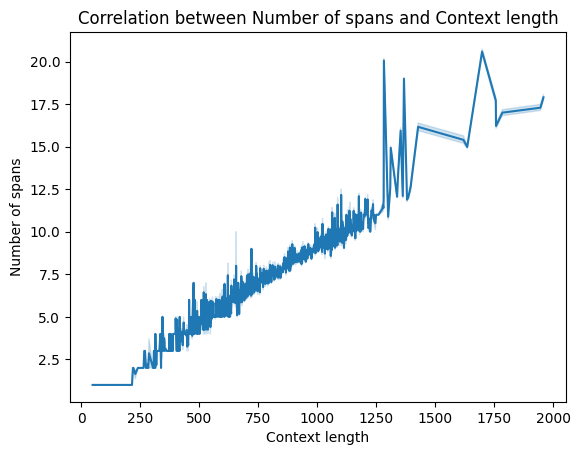

In [55]:
sns.lineplot(x='context_length', y='n_spans', data=qas_df)
plt.xlabel('Context length')
plt.ylabel('Number of spans')
plt.title('Correlation between Number of spans and Context length')
plt.show()

|| Number of spans for each question-answer-document tuple stats:
Maximum of 22 at index<30171>
Mininmun of 1 at index<3635>
Mean is 8.202730797325392
Variance is 3.197723246422617
Median is 8.0


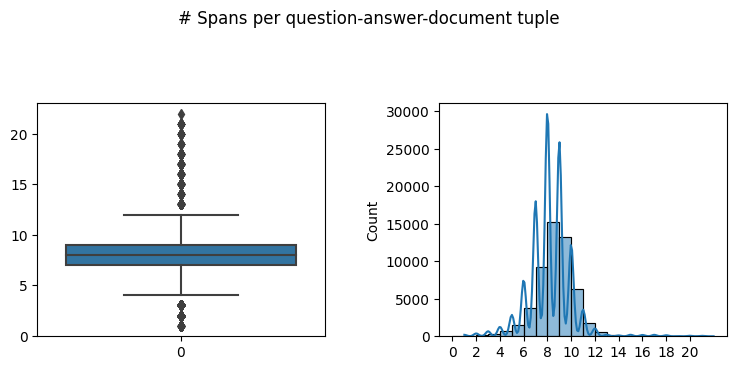

In [56]:
print("|| Number of spans for each question-answer-document tuple stats:")
n_spans = qas_df['n_spans'].to_list()
print_1d_stats(n_spans)
generate_1d_graphs(n_spans, '# Spans per question-answer-document tuple')

In [58]:
qas_df.to_csv(r'C:\Users\vsornapudi\Documents\github\long_doc_runs\data_generated\EDA\dataset_with_n_spans.csv', encoding='utf-8', index=False)